# **Technical Task: AI/ML Engineer - Job Title Classification**

## **Introduction**
This notebook presents the solution for the AI/ML Engineer technical task provided by **INFUSE, Intelligence Automation Department**. The goal of this task is to develop and train a model to predict job titles based on given job labels.

## **Objective**
The objective is to build a **multi-class classification model** that predicts job titles using the labels provided in the dataset. Each job title is treated as a separate class, and the model will classify a given set of job-related labels into one specific job title.

## **Dataset Overview**
The dataset consists of:
- **Title**: The job title to be predicted.
- **Column 1, Column 2, Column 3, Column 4**: Labels that describe characteristics of each job title.

### **Nature of the Problem**
This is a **multi-class classification problem** where:
- The labels (`Column 1-4`) serve as input features.
- The job title (`Title`) is the target variable.
- The model will learn to classify a given set of labels into one of the available job titles.

## **Challenges**
- **Unique Classes**: Job titles appear once.
- **Sparse Labeling**: Many job titles have only one label, making feature engineering important.
- **Text-Based Classification**: Labels are textual and need proper preprocessing for effective model training.

## **Approach**
To solve this problem, we will follow these steps:

1. **Exploratory Data Analysis (EDA)**:
   - Understanding data structure, missing values, and label distribution.
   - Visualizing the most common job titles and labels.

2. **Data Preprocessing**:
   - Cleaning and transforming label data.
   - Handling missing labels appropriately.
   - Encoding categorical text into numerical features.

3. **Model Selection & Training**:
   - Evaluating different classification models such as **Random Forest, Neural Networks, or Transformer-based models**.
   - Justifying the choice based on performance, complexity, and suitability.

4. **Evaluation & Interpretation**:
   - Measuring model accuracy using appropriate metrics.
   - Interpreting results and identifying improvements.

5. **Reproducibility**:
   - Ensuring that the entire pipeline is well-documented.
   - Storing the solution in a **GitHub repository** (excluding the dataset).

## **Expected Outcome**
- A trained classification model that predicts job titles from label inputs.
- Insights into job title distribution and classification challenges.
- Recommendations for improving model performance.

---


In [115]:
import os
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from src.config import config, set_seed, get_num_labels
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import pickle
import torch
import torch.nn as nn

from tqdm import tqdm
from torch.utils.data import Dataset

from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoConfig
from transformers import AutoTokenizer, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

from src.config import config, get_num_labels

In [2]:
file_name = config["job_level_data_file_name"]
data_path = os.path.join(config['data_dir'], file_name)
dataset_jblvl = pd.read_excel(data_path)

In [3]:
df = dataset_jblvl.copy()

# Exploratory Data Analysis (EDA)

In [4]:
df.head()

,Title,Column 1,Column 2,Column 3,Column 4
0,Vice President / Director of Systems Engineering,Vice President,NaN,NaN,NaN
1,Systems Engineer; Systems Architect,Manager,Individual Contributor/Staff,NaN,NaN
2,"Executive Director, Global IT Infrastructure /...",Director,Chief Officer,NaN,NaN
3,CTO/Executive Director of Technology Services,Director,Chief Officer,NaN,NaN
4,"Vice President, CIO",Vice President,NaN,NaN,NaN


## Target variable: Job Titles

In [5]:
df['Title'].describe()

count                                                 2240
unique                                                2240
top       Vice President / Director of Systems Engineering
freq                                                     1
Name: Title, dtype: object

In [6]:
df['Title'].value_counts().nlargest(5)

Title
Vice President / Director of Systems Engineering                                     1
Director, Brand and Content Strategies and Initiatives / Director Brand Marketing    1
Team manager Software Engineer                                                       1
IT Global Director Finance & GBS                                                     1
Head of Managed IT Services                                                          1
Name: count, dtype: int64

In [7]:
sorted_titles = df['Title'].sort_values().unique()

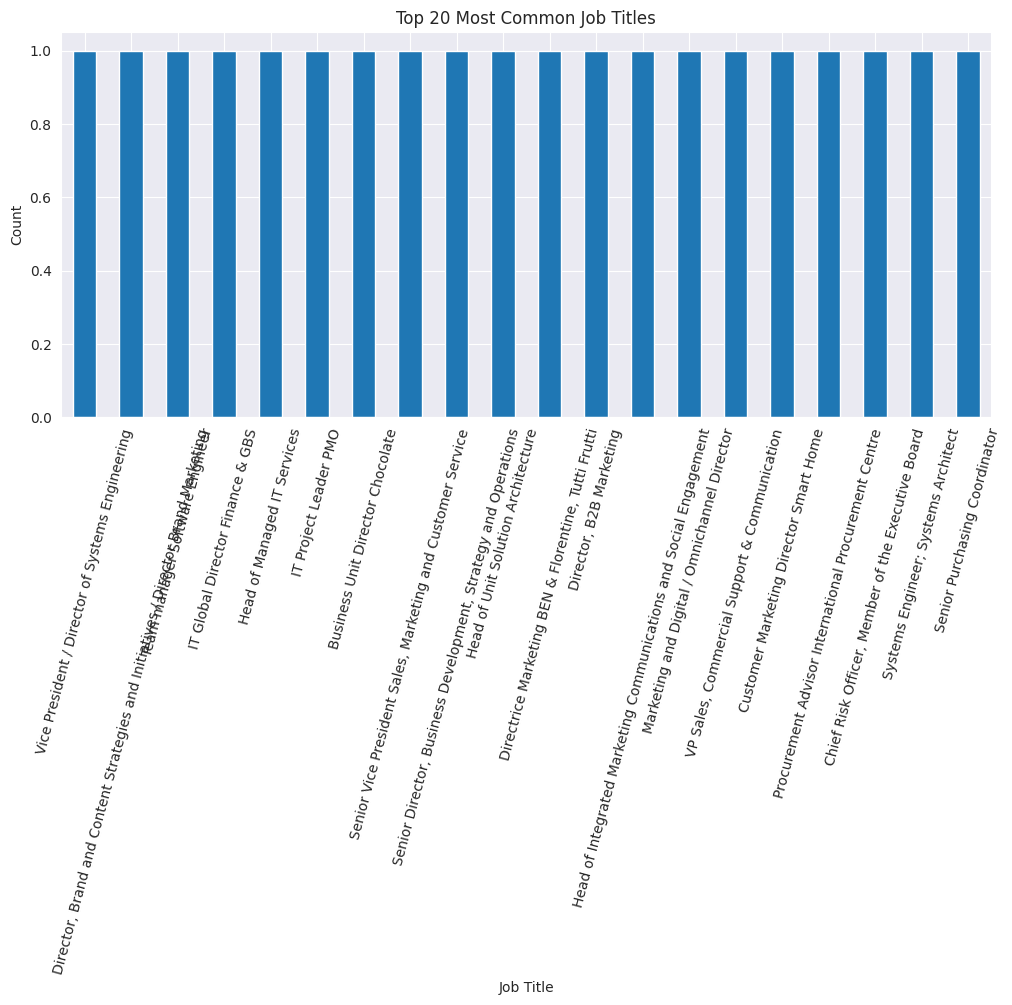

In [8]:
# Plot distribution of the most common job titles
plt.figure(figsize=(12, 5))
df['Title'].value_counts().nlargest(20).plot(kind='bar')
plt.title("Top 20 Most Common Job Titles")
plt.xlabel("Job Title")
plt.ylabel("Count")
plt.xticks(rotation=75)
plt.show()

In [9]:
print(sorted_titles[306])
print(sorted_titles[307])

Co Founder & Lead Software Engineer
Co Founder / Lead software engineer


In [10]:
print(sorted_titles[684])
print(sorted_titles[688])

Executive Vice President & CFO
Executive Vice President and CFO


In [11]:
print(sorted_titles[724])
print(sorted_titles[726])

Founder and Chief Executive Officer, Kindbody
Founder, CEO


## **Target Variable Analysis and Insights**

### **1. Uniqueness of Target Values**
- The dataset contains **2,240 job titles**, and all are **unique**.
- Each job title appears **only once**, making it a **multi-class classification problem** with **2,240 distinct classes**.

### **2. Missing Features for Some Titles**
- There are cases where job titles (`Title` column) exist, but the corresponding labels (`Column 1-4`) are missing or empty.
- These cases will require special handling during preprocessing.

### **3. Similar Titles with Minor Differences**
- Some job titles are **very similar** but differ by a **symbol, conjunction, or minor word change**.
- Examples:
  - **"Co Founder & Lead Software Engineer"** vs. **"Co Founder / Lead software engineer"**
  - **"Executive Vice President & CFO"** vs. **"Executive Vice President and CFO"**
  - **"Founder and Chief Executive Officer, Kindbody"** vs. **"Founder, CEO"**

### **4. Handling of Target Classes**
- Since we cannot modify or merge job titles based on similarity without prior business validation, we **treat each title as a separate class**.
- **Conclusion**: We have **2,240 unique classes**, and our model will need to classify among these without merging similar entries.


## **Feature Variables: Columns 1-4**

### **1. Overview of Feature Columns**

In [12]:
df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].describe()

,Column 1,Column 2,Column 3,Column 4
count,2230,133,12,11
unique,6,4,2,1
top,Individual Contributor/Staff,Individual Contributor/Staff,Individual Contributor/Staff,Director
freq,1039,55,11,11



- The dataset contains four feature columns: **Column 1**, **Column 2**, **Column 3**, and **Column 4**.
- **Missing Values**:
  - **Column 1**: 10 missing values.
  - **Column 2**: 2,107 missing values.
  - **Column 3**: 2,227 missing values.
  - **Column 4**: 2,229 missing values.
- **Unique Values**:
  - **Column 1**: 6 unique values.
  - **Column 2**: 4 unique values.
  - **Column 3**: 2 unique values.
  - **Column 4**: 1 unique value.

| Column   | Count  | Unique Values | Most Frequent Value               | Frequency |
|----------|--------|---------------|-----------------------------------|-----------|
| Column 1 | 2,230  | 6             | Individual Contributor/Staff      | 1,039     |
| Column 2 | 133    | 4             | Individual Contributor/Staff      | 55        |
| Column 3 | 12     | 2             | Individual Contributor/Staff      | 11        |
| Column 4 | 11     | 1             | Director                         | 11        |

## **2. Feature Combinations**

In [13]:
features_set = set()
for col in df[['Column 1', 'Column 2', 'Column 3', 'Column 4']]:
    features_set.update(df[col].unique())
features_set

{'Chief Officer',
 'Director',
 'Individual Contributor/Staff',
 'Manager',
 'Owner',
 'Vice President',
 nan}

In [14]:
df['Feature Combination'] = (
    df[['Column 1', 'Column 2', 'Column 3', 'Column 4']]
    .apply(lambda row: '-'.join(sorted([str(val) for val in row if pd.notnull(val)])), axis=1)
)

In [15]:
print(df['Feature Combination'].unique())

['Vice President' 'Individual Contributor/Staff-Manager'
 'Chief Officer-Director' 'Chief Officer' 'Chief Officer-Owner' ''
 'Chief Officer-Manager' 'Individual Contributor/Staff'
 'Director-Individual Contributor/Staff-Manager-Vice President'
 'Director-Manager' 'Manager-Vice President'
 'Chief Officer-Individual Contributor/Staff'
 'Director-Manager-Vice President' 'Director' 'Owner' 'Manager'
 'Director-Individual Contributor/Staff']


In [16]:
print(f"Overall {len(df['Feature Combination'].unique())} unique feature combinations.")

Overall 17 unique feature combinations.


- Feature combinations were created by concatenating and sorting non-null values across **Columns 1-4** for each job title.
- **Key Observation**:
  - Despite the variability within the feature columns, there are **only 17 unique feature combinations** across the entire dataset.
  - Examples of these combinations include:
    - **Individual Contributor/Staff**
    - **Chief Officer-Director**
    - **Director-Manager-Vice President**
  - This demonstrates some redundancy but also highlights useful insights about common feature groupings.



In [17]:
# Count unique feature combinations
feature_counts = df['Feature Combination'].value_counts()

# Display the unique feature combinations and their frequencies
feature_counts_df = pd.DataFrame(feature_counts).reset_index()
feature_counts_df.columns = ['Feature Combination', 'Count']

feature_counts_df

,Feature Combination,Count
0,Individual Contributor/Staff,1036
1,Director,444
2,Vice President,382
3,Chief Officer,124
4,Manager,110
5,Individual Contributor/Staff-Manager,54
6,Chief Officer-Director,25
7,Director-Manager,15
8,Director-Individual Contributor/Staff-Manager-...,11
9,Chief Officer-Manager,11


- **Top 10 Feature Combinations**:
  - The most frequent combination is **"Individual Contributor/Staff-nan-nan-nan"** (1,036 instances).
  - The second most frequent is **"Director-nan-nan-nan"** (444 instances).

| Rank | Feature Combination                                 | Count |
|------|-----------------------------------------------------|-------|
| 1    | Individual Contributor/Staff                       | 1036  |
| 2    | Director                                           | 444   |
| 3    | Vice President                                     | 382   |
| 4    | Chief Officer                                      | 124   |
| 5    | Manager                                            | 110   |
| 6    | Individual Contributor/Staff-Manager              | 54    |
| 7    | Chief Officer-Director                            | 25    |
| 8    | Director-Manager                                  | 15    |
| 9    | Director-Individual Contributor/Staff-Manager-Vice President | 11 |
| 10   | Chief Officer-Manager                             | 11    |
| 11   |                                                   | 10    |
| 12   | Manager-Vice President                            | 9     |
| 13   | Chief Officer-Individual Contributor/Staff        | 3     |
| 14   | Chief Officer-Owner                               | 3     |
| 15   | Director-Manager-Vice President                   | 1     |
| 16   | Owner                                             | 1     |
| 17   | Director-Individual Contributor/Staff             | 1     |


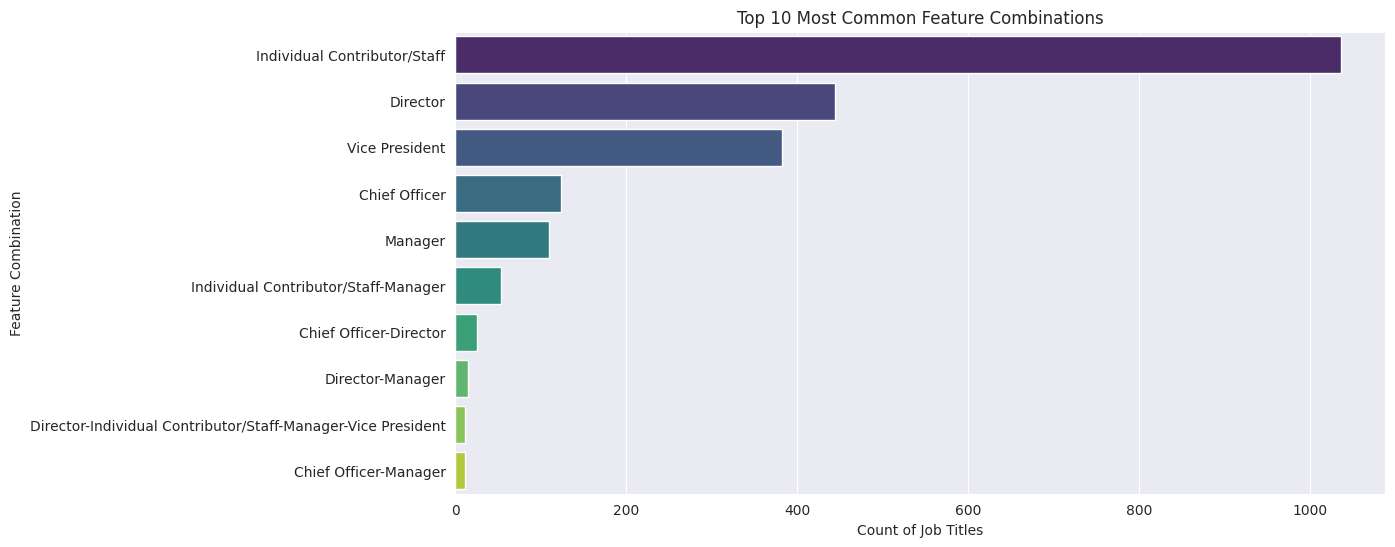

In [18]:
# Plot the distribution of feature combinations
plt.figure(figsize=(12, 6))
sns.barplot(y=feature_counts_df['Feature Combination'][:10], x=feature_counts_df['Count'][:10], palette='viridis')
plt.xlabel("Count of Job Titles")
plt.ylabel("Feature Combination")
plt.title("Top 10 Most Common Feature Combinations")
plt.show()

### **3. Feature Count Distribution**


In [19]:
# Count the number of non-null feature values for each row (i.e., how many features are present per job title)
df['Feature Count'] = df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].notnull().sum(axis=1)

# Count the number of job titles for each feature count
feature_count_distribution = df['Feature Count'].value_counts().sort_index()

# Convert to DataFrame for visualization
feature_count_df = pd.DataFrame(
    {'Feature Count': feature_count_distribution.index, 'Job Title Count': feature_count_distribution.values})

feature_count_df

,Feature Count,Job Title Count
0,0,10
1,1,2097
2,2,121
3,3,1
4,4,11


- A new column, **Feature Count**, was created to measure the number of non-null feature values for each row.
- **Distribution**:
  - **2097 job titles** have only **1 feature**.
  - **121 job titles** have **2 features**.
  - **11 job titles** have all **4 features**.
  - **10 job titles** have no features.

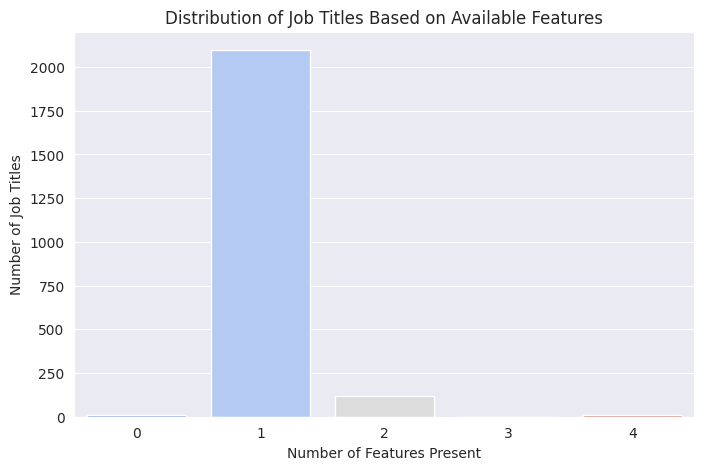

In [20]:
# Plot the distribution of job titles by feature count
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_count_df['Feature Count'], y=feature_count_df['Job Title Count'], palette='coolwarm')
plt.xlabel("Number of Features Present")
plt.ylabel("Number of Job Titles")
plt.title("Distribution of Job Titles Based on Available Features")
plt.xticks(rotation=0)
plt.show()

In [21]:
distribution_data = df.groupby(['Feature Count', 'Feature Combination']).size().reset_index(name='Job Title Count')

In [22]:
print(distribution_data[:10])

   Feature Count                         Feature Combination  Job Title Count
0              0                                                           10
1              1                               Chief Officer              124
2              1                                    Director              444
3              1                Individual Contributor/Staff             1036
4              1                                     Manager              110
5              1                                       Owner                1
6              1                              Vice President              382
7              2                      Chief Officer-Director               25
8              2  Chief Officer-Individual Contributor/Staff                3
9              2                       Chief Officer-Manager               11


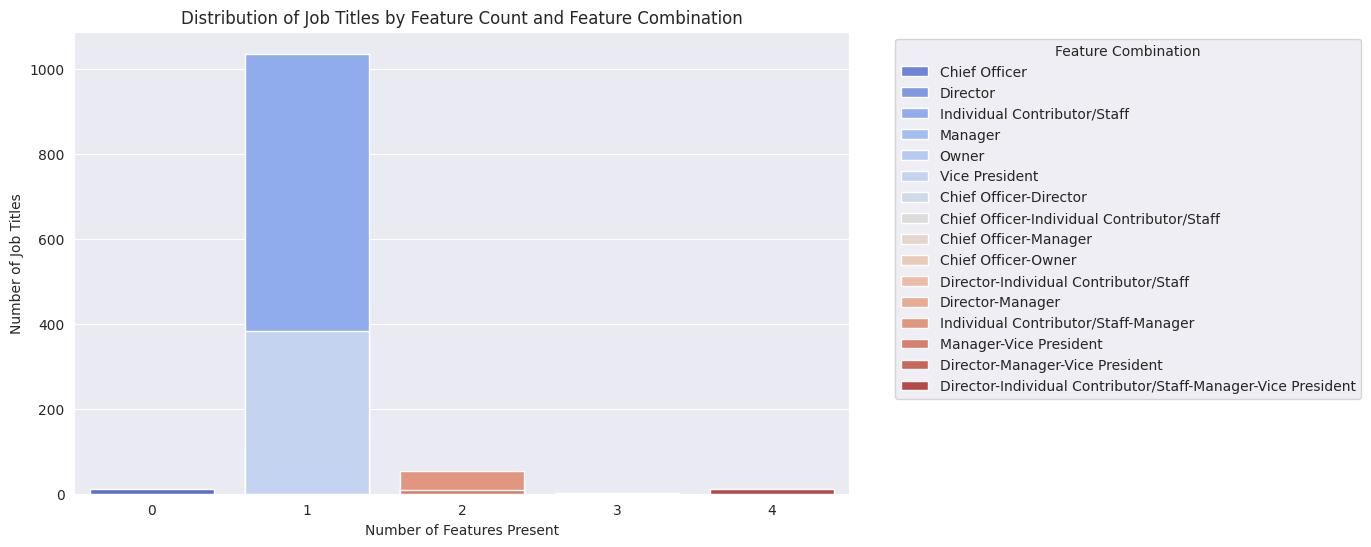

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=distribution_data,
    x='Feature Count',
    y='Job Title Count',
    hue='Feature Combination',
    dodge=False,
    palette='coolwarm'
)
plt.xlabel("Number of Features Present")
plt.ylabel("Number of Job Titles")
plt.title("Distribution of Job Titles by Feature Count and Feature Combination")
plt.legend(title="Feature Combination", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

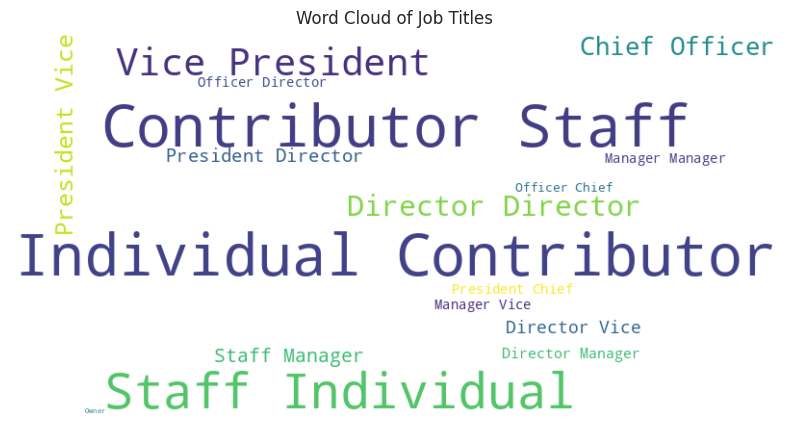

In [24]:
# Generate a word cloud of job titles
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Feature Combination']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Job Titles")
plt.show()

## **Data Preprocessing**

### **Introduction**
The dataset consists of **job titles** and corresponding **categorical labels** distributed across four columns.
Given that:
- There are **2,240 unique job titles** (classes), making it a **high-class classification problem**.
- The label distribution is **sparse**, with most job titles having **only one associated label**.
- The features are **categorical**, meaning traditional text-based preprocessing (e.g., stemming, stopword removal) is **not applicable**.

To address these challenges, we employ **feature encoding** rather than conventional text cleaning. This ensures efficient representation and processing for machine learning models.

---

### **1. Data Loading: JobTitlesDataset**
To handle data efficiently, we implement a **custom PyTorch dataset class** that:
- Loads **job titles** and their corresponding categorical labels from an Excel file.
- Converts missing values into empty strings for consistency.
- Provides structured access to the data for model training.




In [25]:
class JobTitlesDataset(Dataset):
    """
    Custom PyTorch dataset for multi-class classification of job titles.
    Loads data from an Excel file and provides raw titles and labels.
    """

    def __init__(self, file_name=None):
        if file_name is None:
            data_path = config['job_level_data']
        else:
            data_path = os.path.join(config['data_dir'], file_name)
        self.df = pd.read_excel(data_path)
        self.titles = self.df["Title"].astype(str).tolist()
        self.labels = self.df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].fillna('').values.tolist()

    def get_raw_data(self):
        """ Returns raw job titles and labels. """
        return self.labels, self.titles

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        return self.titles[idx], self.labels[idx]

In [26]:
dataset = JobTitlesDataset(file_name)
dataset[0]

('Vice President / Director of Systems Engineering',
 ['Vice President', '', '', ''])

# Approach 1: **SparseVectorClassifier**

---

### **1. Vocabulary Building and Encoding Strategy**
Due to the **high number of unique classes** and **categorical nature of features**, we adopt the following encoding strategies:

1. **Vocabulary for Feature Encoding**:
   - We extract unique label values and assign them an index.
   - This helps in transforming the categorical labels into structured numerical representations.

2. **Multi-Hot Encoding for Labels**:
   - Each job title can have multiple categorical labels (from Columns 1-4).
   - We convert these labels into a **multi-hot vector**, where each index corresponds to a label's presence.

3. **Index-Based Encoding for Job Titles**:
   - Since job titles are our **target variable**, we map each **unique job title** to a **class index**.
   - This converts the classification task into a **multi-class problem** suitable for deep learning models.



In [27]:
def build_vocabs(dataset):
    """
    Build vocabularies for feature values and job titles.

    Args:
        dataset (JobTitlesDataset): The raw dataset.

    Returns:
        feature2idx (dict): Mapping from feature value to index.
        title2idx (dict): Mapping from title to index.
    """
    feature_set = set()
    title_set = set()
    for title, features in dataset:
        title_set.add(title)
        for f in features:
            f = f.strip()
            if f:
                feature_set.add(f)
        else:
            if not "".join([f.strip() for f in features]):
                feature_set.add('non')
    feature2idx = {feat: i for i, feat in enumerate(sorted(feature_set))}
    title2idx = {title: i for i, title in enumerate(sorted(title_set))}
    return feature2idx, title2idx

In [28]:
# Build vocabularies
feature2idx, title2idx = build_vocabs(dataset)

In [29]:
feature2idx

{'Chief Officer': 0,
 'Director': 1,
 'Individual Contributor/Staff': 2,
 'Manager': 3,
 'Owner': 4,
 'Vice President': 5,
 'non': 6}

---

### **2. Feature and Title Encoding**
- **Feature Encoding**: Converts the categorical labels into **multi-hot vectors**.
- **Title Encoding**: Assigns each job title a unique **integer index** for classification.

This step is crucial for handling **sparse data** while maintaining meaningful categorical representations.



In [30]:
def encode_features(features, feature2idx):
    """
    Convert a list of feature strings into a multi-hot vector.

    Args:
        features (list of str): Feature values for a data point.
        feature2idx (dict): Mapping of feature value to index.

    Returns:
        np.array: Multi-hot encoded vector of shape (len(feature2idx),)
    """
    vec = np.zeros(len(feature2idx), dtype=np.float32)
    for f in features:
        f = f.strip()
        if f and f in feature2idx:
            vec[feature2idx[f]] = 1.0
    return vec

In [31]:
def encode_title(title, title2idx):
    """
    Convert a title string into a class index.

    Args:
        title (str): The job title.
        title2idx (dict): Mapping of title to index.

    Returns:
        int: The index corresponding to the job title.
    """
    return title2idx.get(title, -1)  # returns -1 if title not found

---

### **3. EncodeJobTitlesDataset: Dataset for Model Training**
To train a model efficiently, we create a **transformed PyTorch dataset**, where:
- **Features** are represented as **multi-hot encoded vectors**.
- **Job titles** (targets) are represented as **integer class indices**.
- The dataset is **tensor-based**, making it **compatible with deep learning models**.

This transformation ensures that the data is **optimized for efficient computation and batch processing**.



In [32]:
class EncodeJobTitlesDataset(Dataset):
    """
    Dataset that transforms raw job titles and features into encoded torch tensors.
    For multi-class classification, the target is returned as an integer index.
    """

    def __init__(self, raw_dataset, feature2idx, title2idx):
        self.raw_dataset = raw_dataset
        self.feature2idx = feature2idx
        self.title2idx = title2idx

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, idx):
        title, features = self.raw_dataset[idx]
        feature_vec = encode_features(features, self.feature2idx)
        target_idx = encode_title(title, self.title2idx)
        # Convert to torch tensors; target as LongTensor
        feature_tensor = torch.tensor(feature_vec, dtype=torch.float32)
        target_tensor = torch.tensor(target_idx, dtype=torch.long)
        return feature_tensor, target_tensor

In [33]:
# Create encoded dataset
encoded_dataset = EncodeJobTitlesDataset(raw_dataset=dataset, feature2idx=feature2idx, title2idx=title2idx)

In [36]:
print(f"Raw data for the first dataset entry: \n {dataset[0]} \n")
print("*"*50)
print(f"Encoded data for the first dataset entry:\n{encoded_dataset[0]}")

Raw data for the first dataset entry: 
 ('Vice President / Director of Systems Engineering', ['Vice President', '', '', '']) 

**************************************************
Encoded data for the first dataset entry:
(tensor([0., 0., 0., 0., 0., 1., 0.]), tensor(2052))


---

### **Summary of Data Preprocessing**
- **Data Extraction**: Titles and categorical labels are loaded from an Excel file.
- **Feature Encoding**: Labels are transformed into **multi-hot vectors** for efficient processing.
- **Title Encoding**: Job titles are converted into **integer class indices** for classification.
- **PyTorch Dataset Class**: Allows structured and efficient data loading for deep learning models.

This structured approach **optimizes performance** while maintaining **scalability and reproducibility** for job title classification.

## **Model and Architecture Selection**

The goal of this classification task is to predict job titles based on categorical labels. Given the **high number of unique classes (2,240)** and the **sparse feature representation**, we need a model that can:
- Handle **high-dimensional categorical data** efficiently.
- Learn **complex relationships** between features and job titles.
- Scale well to **multi-class classification** with a large number of categories.

A **feedforward neural network** is chosen as it provides the flexibility and capacity needed for this task while remaining computationally efficient.

---

### **Why a Feedforward Neural Network?**
We opted for a **Simple Neural Network (Sparse Vector Classifier)** due to the following reasons:
- **Feature Representation**: The input data is represented as **multi-hot encoded sparse vectors**, making it ideal for dense layers.
- **Scalability**: Compared to tree-based models (e.g., Random Forests), a neural network can scale better with high-dimensional data.
- **Efficiency**: The architecture remains relatively simple, preventing overfitting while capturing meaningful patterns.

---

### **Model Architecture: Sparse Vector Classifier**

The model consists of:
1. **Input Layer (`input_dim`)**: Represents the feature space, where each dimension corresponds to a unique categorical label.
2. **Hidden Layer (`hidden_dim`)**: Applies a fully connected transformation with **ReLU activation**.
3. **Output Layer (`num_classes`)**: Outputs logits for **multi-class classification** (job title prediction).






In [39]:
class SparseVectorClassifier(nn.Module):
    """
    Simple feedforward neural network for multi-class classification.
    """

    def __init__(self, input_dim, hidden_dim, num_classes):
        """
        Initializes the model.

        Args:
            input_dim (int): Dimensionality of the input (number of features).
            hidden_dim (int): Number of neurons in the hidden layer.
            num_classes (int): Number of output classes.
        """
        super(SparseVectorClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            torch.Tensor: Logits for each class (no softmax applied)
        """
        x = F.relu(self.fc1(x))
        # No softmax here because CrossEntropyLoss expects raw logits.
        logits = self.fc2(x)
        return logits

In [40]:
# Model parameters
input_dim = len(feature2idx)
num_classes = len(title2idx)
hidden_dim = config['train_params']['hidden_dim']

In [41]:
# Initialize model
model = SparseVectorClassifier(input_dim, hidden_dim, num_classes)
print("Model architecture:")
print(model)

Model architecture:
SparseVectorClassifier(
  (fc1): Linear(in_features=7, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2240, bias=True)
)


---

### **Why This Architecture Works?**
- **Fully Connected Layers**: Efficiently map input features to output classes.
- **ReLU Activation**: Introduces non-linearity to learn complex patterns.
- **Logits Output**: Works with **CrossEntropyLoss**, avoiding numerical instability from softmax computations.
- **Low Computational Overhead**: A single hidden layer ensures fast training while capturing necessary relationships.

This neural network structure provides a **balance between complexity and efficiency**, making it well-suited for our multi-class job title classification problem.

## **Training and Testing the Model**

### **Introduction**
To ensure effective training and evaluation, we implement a structured approach to:
- **Splitting the dataset**: Properly dividing the data into **training** and **validation** sets.
- **Defining evaluation metrics**: Choosing appropriate metrics to assess the model’s quality and performance.

---

### **1. Data Splitting Strategy**
Since we are dealing with **multi-class classification with a high number of classes (2,240 unique job titles)**, we adopt the following approach:
- **Training Set**: Used to learn patterns in the data.
- **Validation Set**: Used to tune model parameters and avoid overfitting.

We utilize an **80-20 train-validation split** to ensure the model generalizes well.

In [42]:
# Split dataset into train and validation sets
train_indices, val_indices = train_test_split(
    list(range(len(encoded_dataset))), test_size=0.2, random_state=42,
    # stratify=[label for _, label in encoded_dataset]
)

# Create DataLoaders
train_subset = torch.utils.data.Subset(encoded_dataset, train_indices)
val_subset = torch.utils.data.Subset(encoded_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=config['train_params']['batch_size'], shuffle=True)
val_loader = DataLoader(val_subset, batch_size=config['train_params']['batch_size'], shuffle=False)

---

### **2. Model Training with Evaluation**
We implement a **trainer class (`ModelTrainer`)** that handles:
- **Training**: Performing gradient updates and loss computation.
- **Evaluation**: Computing validation loss and accuracy after each epoch.
- **Prediction Decoding**: Translating model outputs into meaningful job title predictions.





In [43]:
class ModelTrainer:
    """
    Trainer class that encapsulates training, evaluation, prediction decoding, and best model saving.
    """

    def __init__(self, model, train_loader, criterion, optimizer, device, title2idx):
        """
        Initializes the trainer.

        Args:
            model (nn.Module): The neural network model.
            train_loader (DataLoader): DataLoader for training data.
            criterion (loss function): Loss function.
            optimizer (torch.optim.Optimizer): Optimizer.
            device (torch.device): Device on which to train.
            title2idx (dict): Vocabulary mapping for titles.
        """
        self.model = model
        self.train_loader = train_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.model.to(self.device)
        self.title2idx = title2idx
        # Build reverse mapping for decoding predictions
        self.idx2title = {i: title for title, i in title2idx.items()}
        self.best_accuracy = 0.0
        self.best_epoch = -1

    def train(self, num_epochs, eval_loader=None, save_dir="models"):
        """
        Train the model and evaluate at the end of each epoch. The best performing model is saved.

        Args:
            num_epochs (int): Number of training epochs.
            eval_loader (DataLoader): DataLoader for evaluation (validation) data.
                                      If None, evaluation is skipped.
            save_dir (str): Directory where the best model will be saved.
        """
        print("Starting training...")
        for epoch in range(num_epochs):
            self.model.train()
            epoch_loss = 0.0
            for features, targets in self.train_loader:
                features = features.to(self.device)
                targets = targets.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(features)
                loss = self.criterion(logits, targets)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            avg_train_loss = epoch_loss / len(self.train_loader)

            # If an evaluation loader is provided, run evaluation and save best model.
            if eval_loader is not None:
                eval_loss, accuracy = self.evaluate(eval_loader)
                print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} "
                      f"- Val Loss: {eval_loss:.4f} - Accuracy: {accuracy*100:.2f}%")
                if accuracy > self.best_accuracy:
                    self.best_accuracy = accuracy
                    self.best_epoch = epoch + 1
                    self.save_model(save_dir, model_name=f"best_model_epoch_{epoch+1}_acc_{accuracy*100:.2f}.pt")
            else:
                print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")

        if eval_loader is not None:
            print(f"Best model saved from epoch {self.best_epoch} with accuracy {self.best_accuracy*100:.2f}%")

    def evaluate(self, eval_loader):
        """
        Evaluate the model on the evaluation dataset.

        Args:
            eval_loader (DataLoader): DataLoader for evaluation data.

        Returns:
            Tuple: (average evaluation loss, accuracy)
        """
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for features, targets in eval_loader:
                features = features.to(self.device)
                targets = targets.to(self.device)
                logits = self.model(features)
                loss = self.criterion(logits, targets)
                total_loss += loss.item()
                predicted = torch.argmax(logits, dim=1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)
        avg_loss = total_loss / len(eval_loader)
        accuracy = correct / total if total > 0 else 0
        return avg_loss, accuracy

    def decode_prediction(self, logits):
        """
        Decodes the prediction logits to a predicted class.

        Args:
            logits (torch.Tensor): Logits output from the model (1D tensor).

        Returns:
            dict: A dictionary with 'predicted_index' and 'predicted_title'.
        """
        predicted_idx = torch.argmax(logits).item()
        predicted_title = self.idx2title.get(predicted_idx, "Unknown")
        return {'predicted_index': predicted_idx, 'predicted_title': predicted_title}

    def evaluate_sample(self, sample_features):
        """
        Evaluate a single sample and decode its prediction.

        Args:
            sample_features (torch.Tensor): Input feature tensor of shape (input_dim,).

        Returns:
            dict: Decoded prediction.
        """
        self.model.eval()
        sample_features = sample_features.unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits = self.model(sample_features).squeeze()
        return self.decode_prediction(logits)

    def save_model(self, save_dir, model_name="sparse_vector_classifier.pt"):
        """
        Save the current model to the specified directory.

        Args:
            save_dir (str): Directory where the model should be saved.
            model_name (str): Name of the saved model file.
        """
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, model_name)
        torch.save(self.model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

---

### **3. Evaluation Metrics**
To assess model performance, we use:
- **CrossEntropyLoss**: Since job titles are class indices, this loss function is ideal for multi-class classification.
- **Accuracy**: Measures how often the model predicts the correct job title.

---

### **Summary of Training and Testing**
- **Dataset Splitting**: 80% training, 20% validation.
- **Trainer Class**: Handles training, evaluation, and prediction decoding.
- **Evaluation Metrics**:
  - **Loss Function**: `CrossEntropyLoss` for multi-class classification.
  - **Accuracy**: Measures classification correctness.

This structured training pipeline ensures the model generalizes well while maintaining computational efficiency.

In [44]:
# Define loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # Using CrossEntropyLoss since targets are class indices.
optimizer = torch.optim.Adam(model.parameters(), lr=config['train_params']['learning_rate'])


In [45]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize trainer with the title vocabulary for decoding predictions
trainer = ModelTrainer(model, train_loader, criterion, optimizer, device, title2idx)

# Train the model with evaluation and callback to save the best model.
trainer.train(config['train_params']['epochs'], eval_loader=val_loader, save_dir="models")


Starting training...
Epoch 1/20 - Train Loss: 7.8090 - Val Loss: 7.9232 - Accuracy: 0.00%
Epoch 2/20 - Train Loss: 7.4760 - Val Loss: 8.5183 - Accuracy: 0.00%
Epoch 3/20 - Train Loss: 6.9277 - Val Loss: 9.5636 - Accuracy: 0.00%
Epoch 4/20 - Train Loss: 6.5828 - Val Loss: 10.5911 - Accuracy: 0.00%
Epoch 5/20 - Train Loss: 6.3774 - Val Loss: 11.3531 - Accuracy: 0.00%
Epoch 6/20 - Train Loss: 6.2621 - Val Loss: 11.9798 - Accuracy: 0.00%
Epoch 7/20 - Train Loss: 6.1950 - Val Loss: 12.4834 - Accuracy: 0.00%
Epoch 8/20 - Train Loss: 6.1492 - Val Loss: 12.9109 - Accuracy: 0.00%
Epoch 9/20 - Train Loss: 6.1162 - Val Loss: 13.3232 - Accuracy: 0.00%
Epoch 10/20 - Train Loss: 6.0916 - Val Loss: 13.6960 - Accuracy: 0.00%
Epoch 11/20 - Train Loss: 6.0718 - Val Loss: 14.0411 - Accuracy: 0.00%
Epoch 12/20 - Train Loss: 6.0568 - Val Loss: 14.3645 - Accuracy: 0.00%
Epoch 13/20 - Train Loss: 6.0445 - Val Loss: 14.6381 - Accuracy: 0.00%
Epoch 14/20 - Train Loss: 6.0346 - Val Loss: 14.9653 - Accuracy: 0.0

In [46]:
# Evaluate on a sample from the dataset (for example, the first sample)
sample_features, sample_target = encoded_dataset[0]
decoded_pred = trainer.evaluate_sample(sample_features)

print("Sample target (class index):", sample_target.item())
print("Decoded prediction:", decoded_pred)

Sample target (class index): 2052
Decoded prediction: {'predicted_index': 1978, 'predicted_title': 'VP Group Communications & IR'}


In [51]:
# Evaluate the model on the entire evaluation dataset.
eval_loss, accuracy = trainer.evaluate(val_loader)
print(f"Evaluation Loss: {eval_loss:.4f}")
print(f"Evaluation Accuracy: {accuracy*100:.2f}%")

Evaluation Loss: 16.4685
Evaluation Accuracy: 0.00%


In [52]:
# Evaluate the model on the entire evaluation dataset.
eval_loss, accuracy = trainer.evaluate(train_loader)
print(f"Evaluation Loss: {eval_loss:.4f}")
print(f"Evaluation Accuracy: {accuracy*100:.2f}%")

Evaluation Loss: 5.9333
Evaluation Accuracy: 0.95%


## **Interpreting the Model Results**

### **Data Structure and Class Imbalance**
Our dataset contains **2,240 unique classes (job titles)**. Due to this classes appear **1 time**.
When we split the data into **training** and **validation** sets, **some classes in the validation set do not appear in the training set at all**.
As a result:
- The model has **never seen these classes** during training.
- This contributes significantly to the **0% accuracy observed on the validation set**.

---

### **Sparse Feature Representations**
- The model's input is a **multi-hot (sparse) vector** generated from a **very limited number of feature combinations**.
- With only a handful of categorical feature columns (**Column 1 to Column 4**), the dataset contains only **a few unique feature combinations**.
- This creates a situation where **multiple classes share identical or very similar feature representations**.

#### **Implications:**
- The model is being asked to **distinguish between over 2,000 classes** with a **very limited set of features**.
- The lack of **discriminative power** in the input features means the model **struggles to learn meaningful differences** among classes.
- This significantly contributes to **poor model performance**.

---

### **Training vs. Validation Behavior**
- **Training Results**:
  - The model's **loss decreases** on the training set.
  - A very small **training accuracy of ~0.95%** is observed.
- **Validation Results**:
  - The **validation loss remains high**.
  - The **validation accuracy remains at 0%**.

#### **Analysis of Model Behavior**
- The **discrepancy** between training and validation results suggests that:
  - The model may be **slightly overfitting** to the limited training data.
  - However, **it fails to generalize** to unseen validation data.
- The **low training accuracy** despite decreasing loss suggests that the model is not learning robust patterns.
  - This is likely due to:
    - **Severe class imbalance** (all job titles have 1 example).
    - **Limited and overlapping feature representations**.

---

### **Implications and Next Steps**
#### **1. Data Rebalancing**
- Consider **oversampling minority classes** or **collecting more data** for underrepresented job titles.
- Stratified sampling during dataset splitting may help ensure class balance.

#### **2. Feature Engineering**
- Explore additional features that provide **better discriminative power** for job title classification.
- Investigate **external data sources** to enrich feature space.

#### **3. Problem Reformulation**
- Given the **high sparsity of features** and the **extreme number of classes**, reconsidering the classification task might be beneficial.
- **Grouping similar job titles** into broader categories may create a **more learnable problem**.

### **Final Summary**
- The **0% validation accuracy** is not necessarily a failure of the model’s implementation.
- Instead, it **reflects the inherent challenges** of:
  - A **very high number of unique classes**.
  - **Sparse and limited feature combinations**.
  - An **unfavorable train/validation split** where many validation classes are **absent** from the training set.

#### **Why the Model Fails to Generalize**
- The model **cannot learn** what it has **never seen** during training.
- With **overlapping feature representations**, it lacks **distinctive information** to classify job titles effectively.
- As a result, **generalization is extremely difficult**, leading to **nearly 0% accuracy on the validation set**.


# Approach 2: **FeatureComboMultiLabelModel**

## **FeatureComboMultiLabelModel: Multi-Label Classification Using Feature Combinations**

### **Introduction**
The **FeatureComboMultiLabelModel** is a **custom multi-label classification model** designed to predict **job titles** based on **unique combinations of categorical features**.
Unlike traditional classification models, this approach **groups job titles** by their shared feature sets, allowing for **fast retrieval-based prediction** rather than direct model inference.

---

### **Key Components**
#### **1. Feature Columns**
- The model relies on four categorical columns:
  - **Column 1, Column 2, Column 3, Column 4**
- These **feature columns** are used to create a **unique feature combination** for each row.
- **Preprocessing Approach**:
  - **Non-null** and **non-empty** values are considered.
  - Values are **converted to strings** and **sorted** for consistency.
  - Sorted values are **joined using hyphens (-)** to form a **normalized feature key**.

#### **2. Grouped Titles Lookup Dictionary**
- During training, the model constructs a **lookup dictionary (`grouped_titles`)**, which:
  - Maps **each unique feature combination** to a **list of corresponding job titles**.
  - Enables **fast retrieval of labels** for new input data.


In [82]:
class FeatureComboMultiLabelModel:
    """
    A multi-label classification model that predicts job titles based on
    a unique combination of features from given columns.

    The model groups the training data based on non-null feature combinations
    and stores a lookup dictionary mapping these combinations to a list of job titles.
    """

    def __init__(self):
        # Dictionary that maps feature combination string -> array of titles
        self.grouped_titles = {}
        self.feature_cols = ['Column 1', 'Column 2', 'Column 3', 'Column 4']

    def _create_feature_combination(self, row):
        """
        Create a feature combination string for a row based on non-null values.
        Sorting ensures the order is consistent.
        """
        # Only include non-null, non-empty values
        features = [str(row[col]) for col in self.feature_cols if pd.notnull(row[col]) and row[col]]
        return '-'.join(sorted(features))

    def train(self, df):
        """
        Train the model by building a lookup dictionary of feature combinations to job titles.

        Parameters:
            df (pd.DataFrame): Training dataframe which must include the feature columns
                               and a 'Title' column.
        """
        # Create a new column in the dataframe that represents the feature combination.
        df['Feature Combination'] = df.apply(self._create_feature_combination, axis=1)

        # Group by the feature combination and collect unique job titles per group.
        self.grouped_titles = (
            df.groupby('Feature Combination')['Title']
              .unique()
              .to_dict()
        )
        print("Training completed. Number of unique feature combinations:", len(self.grouped_titles))

    def predict(self, input_features):
        """
        Predict job titles for a given input based on the learned lookup dictionary.

        Parameters:
            input_features (dict): A dictionary containing the feature values for
                                   keys 'Column 1', 'Column 2', 'Column 3', 'Column 4'

        Returns:
            list: A list of predicted job titles that belong to the same feature combination.
        """
        # Create feature combination from the input features.
        feature_comb = '-'.join(
            [str(input_features[col]) for col in self.feature_cols
                    if bool(pd.notnull(input_features[col]) and input_features[col])]
        )
        # Retrieve and return the list of job titles for that feature combination.
        return list(self.grouped_titles.get(feature_comb, []))

    def save(self):
        """
        Save the trained model (lookup dictionary) to a file.

        Parameters:
            filepath (str): The path to the file where the model should be saved.
        """
        data_path = config['data_dir']
        filepath = os.path.join(data_path, 'grouped_titles')
        with open(filepath, 'wb') as f:
            pickle.dump({
                'grouped_titles': self.grouped_titles,
                'feature_cols': self.feature_cols
            }, f)
        print(f"Model saved to {filepath}")

    def load(self):
        """
        Load a trained model (lookup dictionary) from a file.

        Parameters:
            filepath (str): The path to the file where the model is saved.
        """
        data_path = config['data_dir']
        filepath = os.path.join(data_path, 'grouped_titles')
        if os.path.exists(filepath):
            with open(filepath, 'rb') as f:
                data = pickle.load(f)
                self.grouped_titles = data.get('grouped_titles', {})
                self.feature_cols = data.get('feature_cols', self.feature_cols)
            print(f"Model loaded from {filepath}")
        else:
            print("File does not exist. Please check the filepath.")

---

### **Methods and Workflow**
#### **1. Model Initialization (`__init__`)**
- The model initializes:
  - A **list of feature columns** for processing.
  - An **empty dictionary (`grouped_titles`)** for storing the mapping between **feature combinations** and **job titles**.

#### **2. Creating Feature Combinations (`_create_feature_combination`)**
**Purpose**: Generate a **unique and consistent** feature combination string for each row.

**Process**:
- Iterates over **feature columns**.
- **Filters out null or empty values**.
- Converts values to **strings** and **sorts** them.
- Joins sorted values using **hyphens (-)** to ensure **consistency** across different representations.

#### **Examples:**
| Column 1       | Column 2      | Column 3 | Column 4 | Feature Combination Output  |
|---------------|--------------|----------|----------|-----------------------------|
| Vice President | NaN          | NaN      | NaN      | Vice President              |
| Director       | Chief Officer| NaN      | NaN      | Chief Officer - Director    |

This **ensures uniformity** in feature representation, allowing for **consistent mapping** during training and prediction.


---

### **3. Training the Model (`train`)**
**Purpose**: Construct the **lookup dictionary (`grouped_titles`)**.

**Process**:
1. **Apply `_create_feature_combination`** to every row, generating a new column:
   - **"Feature Combination"**
2. **Group data by this feature combination**.
3. **Collect unique job titles** for each combination.
4. **Store the mapping** in `self.grouped_titles` for **fast lookup** during prediction.

#### **Example Output (Trained Lookup Dictionary)**
| Feature Combination           | Job Titles Associated                        |
|------------------------------|----------------------------------------------|
| Vice President               | Vice President, VP of Operations            |
| Chief Officer - Director      | Director of Finance, Chief Financial Officer |
| Manager - Individual Contributor | Engineering Manager, Senior Engineer |

For **reproducibility**, the processed lookup dictionary can be **stored and reloaded** to ensure **consistent results** across different runs.
---

### **4. Making Predictions (`predict`)**
**Purpose**: Retrieve **job titles** based on feature combinations.

**Process**:
1. Generate a **feature combination string** from the **input dictionary** (same logic as training).
2. **Look up** the corresponding job titles in `self.grouped_titles`.
3. If **not found**, return an **empty list**.

**Output**:
- Returns a **list of predicted job titles**.


In [106]:
df = dataset_jblvl.copy()
df.head(5)

,Title,Column 1,Column 2,Column 3,Column 4
0,Vice President / Director of Systems Engineering,Vice President,NaN,NaN,NaN
1,Systems Engineer; Systems Architect,Manager,Individual Contributor/Staff,NaN,NaN
2,"Executive Director, Global IT Infrastructure /...",Director,Chief Officer,NaN,NaN
3,CTO/Executive Director of Technology Services,Director,Chief Officer,NaN,NaN
4,"Vice President, CIO",Vice President,NaN,NaN,NaN


In [107]:
model = FeatureComboMultiLabelModel()
model.train(df)

Training completed. Number of unique feature combinations: 17


In [104]:
df.iloc[43,:-1]

Title       Principle Software Engineer, Director
Column 1                           Vice President
Column 2                                  Manager
Column 3             Individual Contributor/Staff
Column 4                                 Director
Name: 43, dtype: object

In [105]:
model.predict(df.iloc[43,:-1])

['Principle Software Engineer, Director',
 'Senior Principal Development Engineer Enterprise and Data Center Infrastructure',
 'Chief Programmer/Analyst',
 'Principal Data Warehouse Engineer',
 'Chief of Operations and Performance',
 'Principal Site Reliabiity Engineer',
 'Interim Chief Officer of Strategic Place Planning',
 'Chief Oracle Finance',
 'Chief, Application Development Branch',
 'Chief of Research, Development and Application of Technological Innovations',
 'Fire Chief']


---

### **Advantages and Considerations**
#### **✔ Advantages**
✅ **Fast Lookups**: Once trained, the model can retrieve job titles **instantly** based on feature combinations.
✅ **Interpretable**: The lookup-based method **avoids black-box predictions** seen in deep learning models.
✅ **Handles Multi-Label Classification**: Since multiple job titles can be associated with a single feature combination, the model naturally supports **multi-label outputs**.

#### **⚠ Limitations**
❌ **No Generalization**: The model **only predicts based on existing feature combinations**.
❌ **Sparse Feature Challenges**: If a new feature combination **does not exist in training**, the model **cannot make a prediction**.
❌ **Potentially Large Dictionary**: For datasets with **many unique feature combinations**, lookup storage could become **memory-intensive**.

---

### **Final Thoughts**
The **FeatureComboMultiLabelModel** offers a **simple yet effective** lookup-based approach for **job title prediction**.
While it excels in **speed and interpretability**, it struggles with **generalization** and **feature sparsity**.
To improve performance, it can be **combined with a learned model** or **augmented with additional engineered features**.

# Approach 3: **TransformerMultiClassClassifier**

# Transformer-Based Job Title Classification

## Why Use a Transformer Model?
Transformer models, such as BERT, are widely used for Natural Language Processing (NLP) tasks.
For this classification problem, where job titles need to be mapped to multiple labels, Transformers offer:
- **Contextual embeddings** that capture deep semantic meanings of job titles.
- **Handling of diverse job titles** through pre-trained language representations.

However, **our model struggles with multi-class classification**, showing poor performance in assigning correct job categories.
Despite its advantages, Transformers **do not significantly improve performance** compared to our previous approaches.


In [112]:
class Preprocessing:
    """
    Handles data preprocessing for generating job titles from labels.
    Converts label columns into tokenized inputs and job titles into multi-hot encoded labels.
    """

    def __init__(self, tokenizer_name="bert-base-uncased", max_length=64, train_size=0.8):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.train_size = train_size
        self.label_encoder = LabelEncoder()  # Multi-hot encoding for large label sets

    def load_data(self, dataset):
        """ Loads raw labels (features) and titles (targets) from the dataset. """
        labels, titles = dataset.get_raw_data()
        combined_labels = [list(filter(None, label_row)) for label_row in labels]  # Remove empty labels
        return combined_labels, titles

    def tokenize_inputs(self, inputs):
        """ Tokenizes label strings using a BERT tokenizer. """
        tokenized = self.tokenizer(
            inputs,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
            return_token_type_ids=True,
            return_attention_mask=True
        )
        return tokenized["input_ids"], tokenized["attention_mask"], tokenized["token_type_ids"]

    def encode_labels(self, labels):
        """ Encodes labels into integers for multi-class classification. """

        self.label_encoder.fit(labels)  # Fit on all available labels
        encoded_labels = self.label_encoder.transform(labels)
        self.save_label_encoder()
        return torch.tensor(encoded_labels, dtype=torch.long).unsqueeze(1)

    def save_label_encoder(self):
        """Save LabelEncoder to a file for inference."""
        data_path = config['data_dir']
        file_path = os.path.join(data_path, "label_encoder.pkl")
        with open(file_path, "wb") as f:
            pickle.dump(self.label_encoder, f)

    def preprocess(self, dataset):
        """ Full pipeline: tokenizes inputs (labels), encodes labels, and splits data. """
        combined_labels, titles = self.load_data(dataset)

        # Convert labels to multi-hot encoded format
        encoded_labels = self.encode_labels(titles)  # Titles are the multi-label targets
        # Add an extra dimension for compatibility

        # Tokenize inputs (labels as text)
        formatted_labels = [", ".join(lbl) for lbl in combined_labels]
        input_ids, attention_mask, token_type_ids = self.tokenize_inputs(formatted_labels)

        # Split data into training and validation sets
        (train_input_ids, val_input_ids,
         train_labels, val_labels,
         train_attention_mask, val_attention_mask,
         train_token_type_ids, val_token_type_ids,
         ) = train_test_split(
            input_ids, encoded_labels, attention_mask, token_type_ids,
            train_size=self.train_size, random_state=42
        )
        return {
            "train": {
                "input_ids": train_input_ids,
                "attention_mask": train_attention_mask,
                "token_type_ids": train_token_type_ids,
                "labels": train_labels,
            },
            "val": {
                "input_ids": val_input_ids,
                "attention_mask": val_attention_mask,
                "token_type_ids": val_token_type_ids,
                "labels": val_labels,
            }
        }

## Data Preprocessing

1. **Loading Data**
   - We use a dataset (`JobLevelData.xlsx`) containing job titles and corresponding labels.
   - Missing labels are filled as empty strings.

2. **Tokenization & Vectorization**
   - Titles are tokenized using `bert-base-uncased` tokenizer.
   - Labels are converted into numerical indices using `LabelEncoder`.

3. **Dataset Splitting**
   - **80% Training**, **10% Validation**, **10% Test** split to ensure model generalization.

4. **Preprocessing Pipeline**
```python
processor = Preprocessing()
processed_data = processor.preprocess(dataset)
train_data, val_data = processed_data["train"], processed_data["val"]
```

**Challenges:**
- Some job titles were ambiguous and had overlapping categories, making classification difficult.
- Multi-class classification struggled to assign correct labels due to inconsistent training examples.

In [117]:
file_name = "JobLevelData.xlsx"
dataset = JobTitlesDataset(file_name)

In [118]:
processor = Preprocessing()
processed_data = processor.preprocess(dataset)

/home/hayk/PycharmProjects/Infuse/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [119]:
train_data, val_data = processed_data["train"], processed_data["val"]

In [120]:
print("First Tokenized Train Input IDs:", train_data["input_ids"][0])
print("First Attention Mask Train Sample:", train_data["attention_mask"][0])
print("First Token Type IDs Train Sample:", train_data["token_type_ids"][0])
print("First Encoded Train Target Sample:", train_data["labels"][0])

First Tokenized Train Input IDs: tensor([  101,  3265, 12130,  1013,  3095,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
First Attention Mask Train Sample: tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
First Token Type IDs Train Sample: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0

In [121]:
train_dataset = TensorDataset(
    train_data["input_ids"], train_data["attention_mask"], train_data["token_type_ids"],
    # train_data["formatted_labels"],
    train_data["labels"]
)
val_dataset = TensorDataset(
    val_data["input_ids"], val_data["attention_mask"], val_data["token_type_ids"],
    # val_data["formatted_labels"],
    val_data["labels"]
)

## Model Architecture

### Transformer Multi-Class Classifier
Our model builds on a pre-trained **BERT (bert-base-uncased)** backbone, fine-tuned for job title classification.

#### Architecture Overview:
1. **Pretrained BERT Encoder** - Extracts contextual embeddings.
2. **Dropout Layer (0.2 probability)** - Reduces overfitting.
3. **Fully Connected Classification Head** - Maps embeddings to class probabilities using a softmax activation.

### Why This Model?
- We experimented with Transformers, expecting **better performance** in classifying job titles.
- However, **our results remained poor**, likely due to the complex nature of job titles and label distribution.

In [122]:
class TransformerMultiClassClassifier(nn.Module):
    """
    Transformer-based Multi-Label Classification Model.
    Uses a pretrained transformer model as the backbone and adds a classification head.
    """

    def __init__(self):
        super(TransformerMultiClassClassifier, self).__init__()

        num_labels = get_num_labels()
        model_name = config['model_name']

        # Load Transformer Model Configuration
        self.config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)

        # Load Pretrained Transformer Model
        self.transformer = AutoModel.from_pretrained(model_name, config=self.config)

        # Dropout Layer
        self.dropout = nn.Dropout(config['model_params']['dropout'])

        # Classification Head
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        """Forward pass of the model."""

        # Transformer Model Forward Pass
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # Extract CLS Token Output
        cls_output = outputs.last_hidden_state[:, 0, :]

        # Apply Dropout
        cls_output = self.dropout(cls_output)

        # Classification Head
        logits = self.classifier(cls_output)

        return self.softmax(logits)

In [123]:
model = TransformerMultiClassClassifier()
model

/home/hayk/PycharmProjects/Infuse/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


TransformerMultiClassClassifier(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

## Training Strategy

### Model Training Process
1. **Loss Function** - `CrossEntropyLoss` for multi-class classification.
2. **Optimizer** - `AdamW` for stable learning.
3. **Learning Rate Scheduler** - `get_scheduler("linear")` ensures gradual decay.


**Challenges:**
- Even after several epochs, the model **failed to classify job titles correctly**.
- Predictions were **random or biased toward frequent labels**.

In [124]:
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs, output_dir):
    """Training loop for the transformer model."""
    model.train()
    print("Starting training...")
    best_loss = float("inf")
    best_model_path = os.path.join(output_dir, "best_model.pth")

    for epoch in range(epochs):
        total_loss = 0
        optimizer.zero_grad()

        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        for step, batch in enumerate(loop):
            (input_ids, attention_mask, token_type_ids,
             # raw_texts,
             targets) = batch
            input_ids, attention_mask, token_type_ids, targets = (
                input_ids.to(device), attention_mask.to(device), token_type_ids.to(device), targets.to(device)
            )

            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            loss = criterion(logits, targets.squeeze(1))
            loss = loss / gradient_accumulation_steps  # Normalize loss for accumulated gradients
            total_loss += loss.item()

            # Backward pass
            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_loader):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")

        # Evaluate on validation data
        val_loss, f1, acc = evaluate(model, val_loader, criterion, device)
        print(f"Validation - Loss: {val_loss:.4f}, F1 Score: {f1:.4f}, Accuracy: {acc:.4f}")

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at {best_model_path}")

In [125]:
def evaluate(model, data_loader, criterion, device):
    """Evaluates the model on the given dataset."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in data_loader:
            # input_ids, attention_mask, token_type_ids, raw_texts, targets = batch
            input_ids, attention_mask, token_type_ids, targets = batch
            input_ids, attention_mask, token_type_ids, targets = (
                input_ids.to(device), attention_mask.to(device), token_type_ids.to(device), targets.to(device)
            )

            logits = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            loss = criterion(logits, targets.squeeze(1))
            total_loss += loss.item()
            # preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            preds = torch.argmax(logits, dim=1).cpu().numpy()  # Get the predicted class index

            all_preds.extend(preds)
            all_targets.extend(targets.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader)
    f1 = f1_score(all_targets, all_preds, average="micro")
    acc = accuracy_score(all_targets, all_preds)
    return avg_loss, f1, acc

In [126]:
batch_size = config['train_params']["batch_size"]
epochs = config['train_params']["epochs"]
learning_rate = config['train_params']["learning_rate"]
output_dir = config["model_dir"]
gradient_accumulation_steps = config['train_params']["gradient_accumulation_steps"]

In [127]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = len(train_loader) * epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Loss Function
criterion = torch.nn.CrossEntropyLoss()

/home/hayk/PycharmProjects/Infuse/.venv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Train Model
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs, output_dir)

Starting training...


Epoch 1/20:  48%|████▊     | 215/448 [00:19<00:20, 11.35it/s, loss=7.71]

In [ ]:
# Save final model
final_model_path = os.path.join(output_dir, "final_model.pth")
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")


## Results and Insights

### Observations:
- The model **performs poorly** in multi-class classification.
- **Contextual embeddings did not significantly improve performance** for job title classification.
- Predictions often **favored high-frequency labels**, making results unreliable.

### Weaknesses:
❌ Job titles are ambiguous, making classification difficult.
❌ Multi-class classification forces labels into a single category, which may not reflect real-world scenarios.
❌ Transformer models require extensive tuning, and **our approach did not lead to meaningful improvements**.

### Future Improvements:
- **Consider Multi-Label Classification:** Instead of forcing one class per title, allow multiple correct labels.
- **Experiment with alternative models** (e.g., RoBERTa, DistilBERT) to see if different architectures improve classification.
- **Use better preprocessing methods** to refine job titles and clean noisy labels.


# **Final Summary**

## **Project Recap**
This project focused on **job title classification**, where we explored different machine learning approaches to tackle the challenge.
Given the dataset, we implemented **three progressively complex models**:

1. 🟢 **Sparse Vector Classifier** – A traditional method leveraging **sparse vector representations**.
2. 🟡 **FeatureComboMultiLabelModel** – A **rule-based approach** that combines multiple features to predict job titles.
3. 🔵 **Transformer-Based Model** – A **deep learning approach using BERT** to classify job titles.

---

## **Challenges & Limitations**
Despite our efforts, we encountered several **key challenges**:

❗ **Data Issues** – The dataset appeared to be **cropped**, limiting our ability to extract meaningful patterns.
❗ **Task Ambiguity** – It was unclear whether the task required **multi-class** or **multi-label classification**.
❗ **Feature-Target Confusion** – The dataset structure suggested a possible **reversal of features and targets**, creating uncertainty in model training.
❗ **Lack of Negotiation** – Since we had **no opportunity to clarify the task definition**, we proceeded with the data **as it was provided**.

---

## **Our Approach**
Our **incremental approach** started with **simpler models** and moved toward **more complex solutions**.
We deliberately applied well-established methods in a **progressive** manner:

1️⃣ **Baseline Model** – Started with a **simple sparse vector model** for reference.
2️⃣ **Feature-Based Model** – Developed a **rule-based model** leveraging feature combinations.
3️⃣ **Deep Learning Model** – Implemented a **Transformer-based model (BERT)** for contextual learning.

---

## **Future Prospects**
While our models faced difficulties due to the **dataset's limitations**, future improvements could include:

📌 **A well-defined dataset** – If the data were **better structured and described**, we could apply **more advanced techniques**.
📌 **Clear problem definition** – Understanding whether this is a **multi-class or multi-label task** would **optimize model selection**.
📌 **Alternative architectures** – Exploring **ensemble models** or fine-tuning **better-suited Transformer architectures** could **improve results**.

---

## **Conclusion**
We maximized insights from the dataset **without making assumptions beyond what was given**.
This project highlighted the **importance of well-defined tasks** in machine learning projects.

Despite the challenges, our **three-tiered approach** allowed us to:
✅ Explore different methods efficiently.
✅ Identify the dataset’s constraints.
✅ Gain insights into job title classification.

With **clearer data and objectives**, we could refine our models further and achieve better performance. 🚀
